In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from IPython import display
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score,RepeatedKFold,RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve

In [2]:
#Read CSV
df= pd.read_csv("spotify.csv")
#Dropping NAs
df = df.dropna()

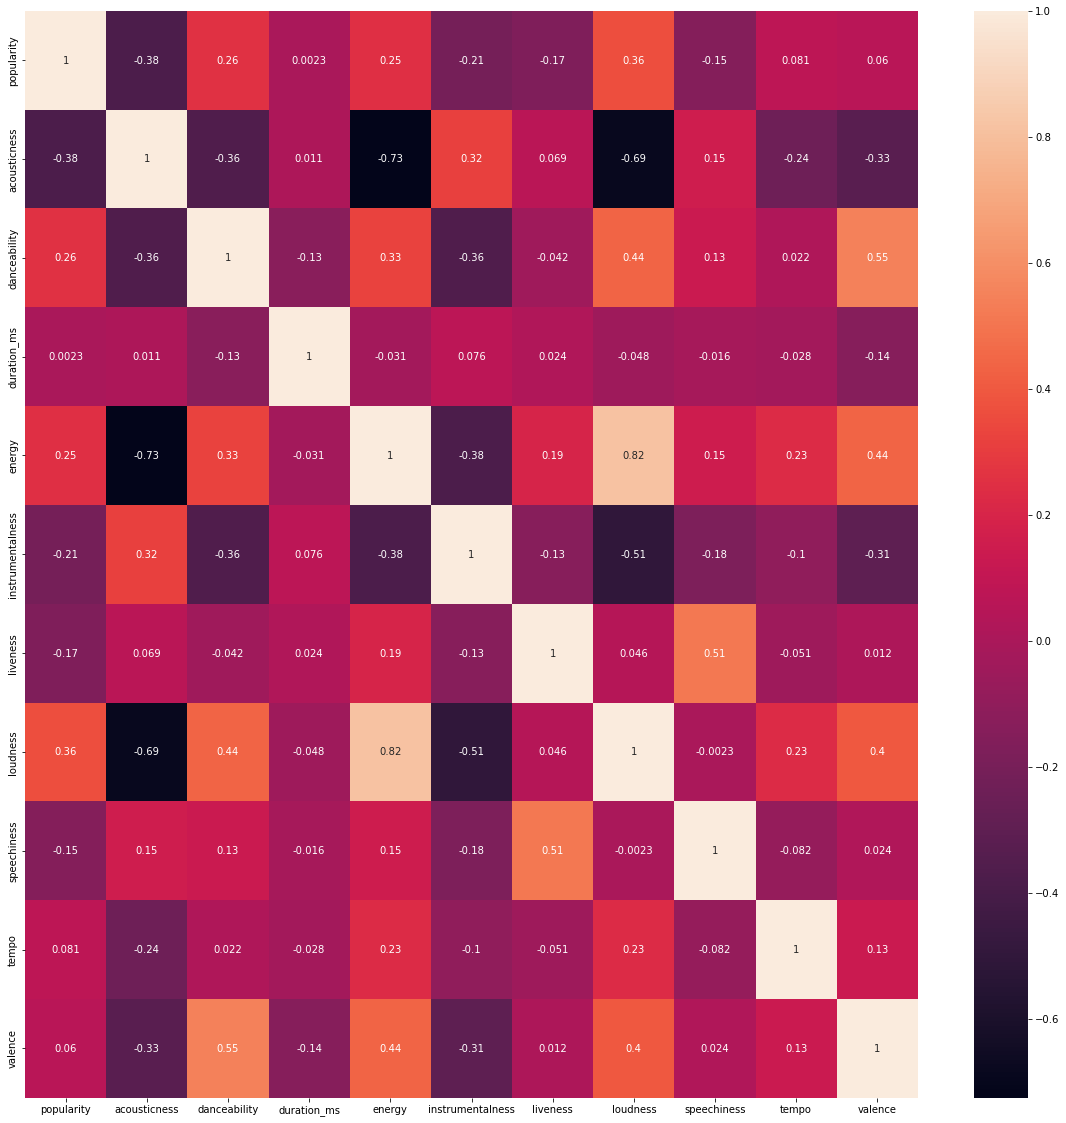

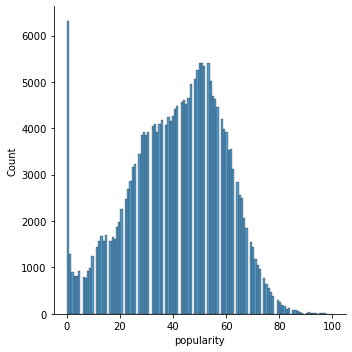

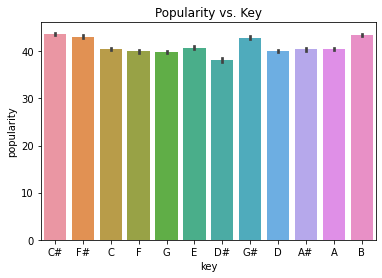

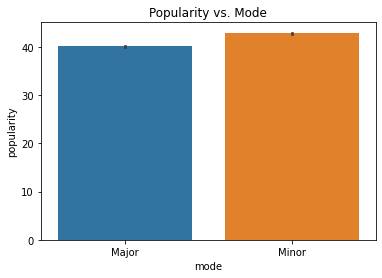

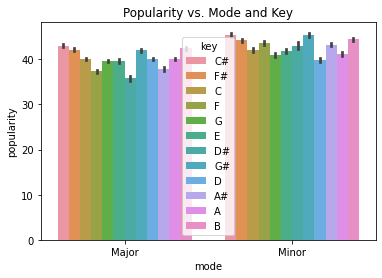

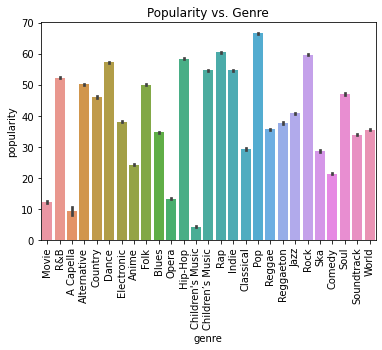

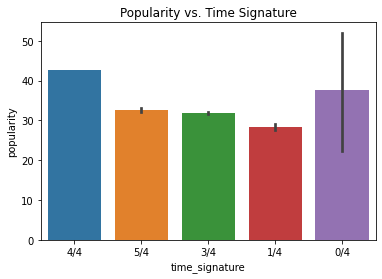

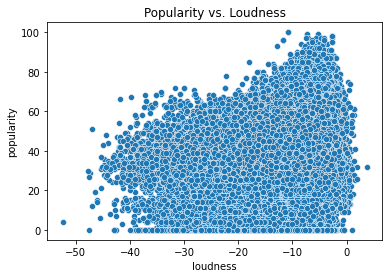

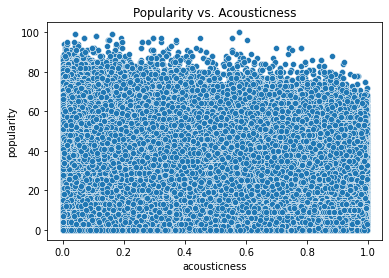

In [3]:
#Heatmap to show correlation between all features
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, ax=ax)
plt.show()
#Popularity Distribution
sns.displot(df['popularity'])
plt.show()
#Plots
sns.barplot(x = 'key', y = 'popularity', data = df)
plt.title('Popularity vs. Key')
plt.show()
sns.barplot(x = 'mode', y = 'popularity', data = df)
plt.title('Popularity vs. Mode')
plt.show()
sns.barplot(x = 'mode', y = 'popularity', hue = 'key', data = df)
plt.title('Popularity vs. Mode and Key')
plt.show()
sns.barplot(x = 'genre', y = 'popularity', data = df)
plt.title('Popularity vs. Genre')
plt.xticks(rotation=90)
plt.show()
sns.barplot(x = 'time_signature', y = 'popularity', data = df)
plt.title('Popularity vs. Time Signature')
plt.show()
sns.scatterplot(x = 'loudness', y = 'popularity', data = df)
plt.title('Popularity vs. Loudness')
plt.show()
sns.scatterplot(x = 'acousticness', y = 'popularity', data = df)
plt.title('Popularity vs. Acousticness')
plt.show()

* ‘Loudness’ has the highest positive correlation with popularity, and ‘acousticness’ has the highest negative correlation with popularity.
* ‘Energy’ and ‘acousticness’ have a highly-correlated inverse relationship. The more a song is acoustic, the less energy it tends to be.
* Popularity distribution graph shows how the various popularity scores are distributed, with very few samples of actual "popular" songs above a score of 80, and many songs with popularity 0.
* The remaining graphs show the relationship between popularity and a few other features.

In [4]:
#Grouping popularity into 4 categorical classes
df.loc[df['popularity'] < 26, 'popularity'] = 0 
df.loc[(df['popularity'] >= 26) & (df['popularity'] < 51), 'popularity'] = 1
df.loc[(df['popularity'] >= 51) &  (df['popularity'] < 76), 'popularity'] = 2
df.loc[df['popularity'] >= 76, 'popularity'] = 3
#Displaying the number of samples in each class
df['popularity'].value_counts()
#Cleaning columns
df.loc[(df['genre'] =="Children’s Music") | (df['genre'] =="Children's Music"), 'genre'] = "Children's Music"
#One Hot Encoding
df = pd.get_dummies(df, columns = ['genre', 'time_signature', 'key', 'mode'] )
#Removing duplicate data
df = df.drop_duplicates(subset=['track_id'])
#Dropping unnecessary columns
df = df.drop(columns=['track_name', 'track_id', 'artist_name'])

<AxesSubplot:>

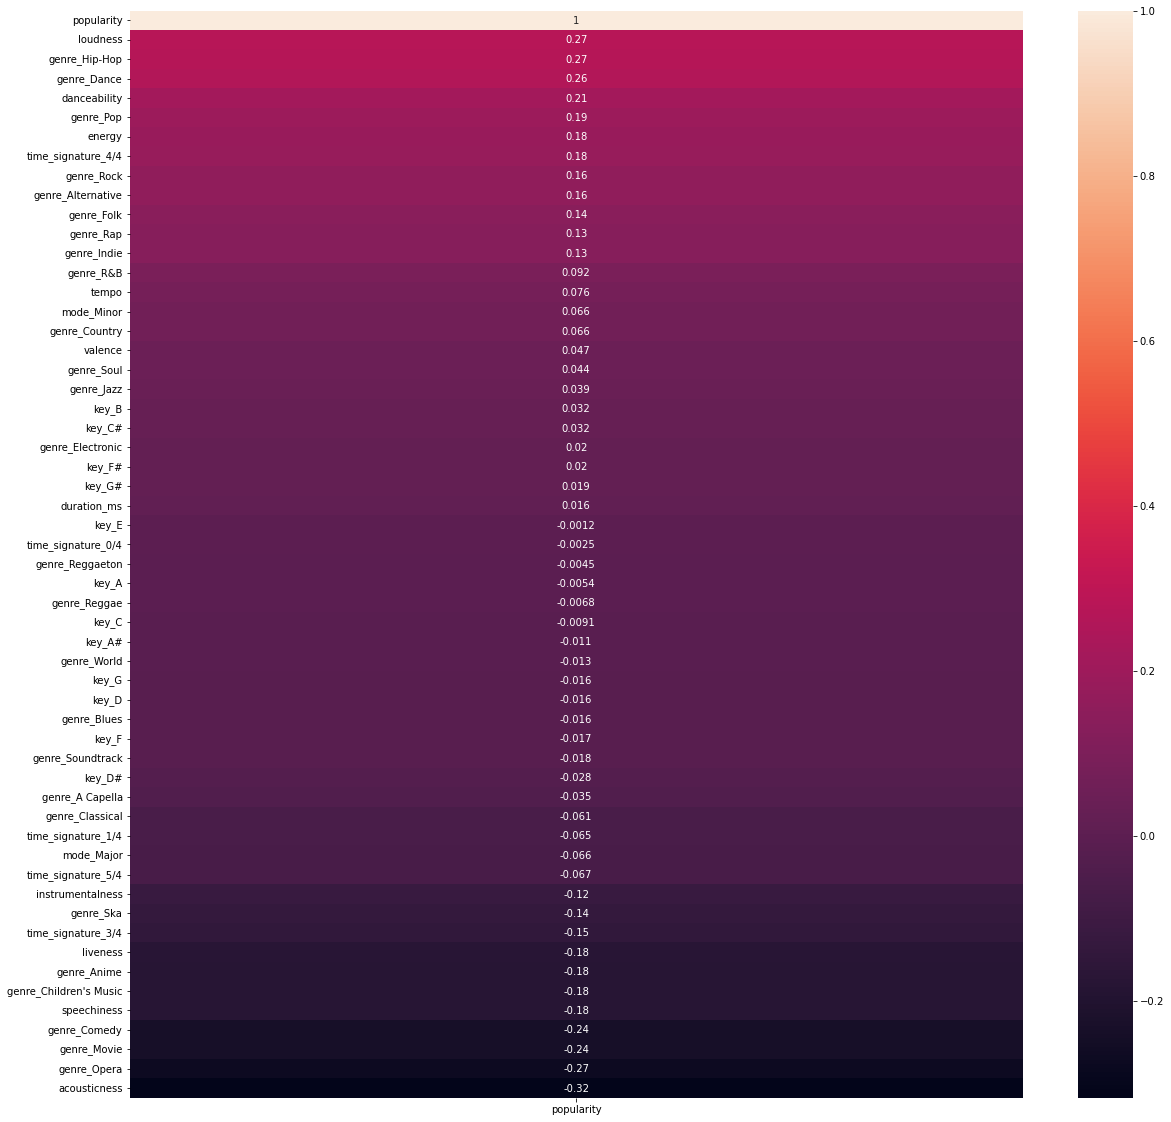

In [5]:
#Heatmap to show correlation between features and target
corr = df.corr()[['popularity']].sort_values(by='popularity', ascending=False)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, annot=True, ax=ax)

In [6]:
target = 'popularity'
X_cols = df.loc[:, df.columns != target].columns
X = df[X_cols]
y = df[target]

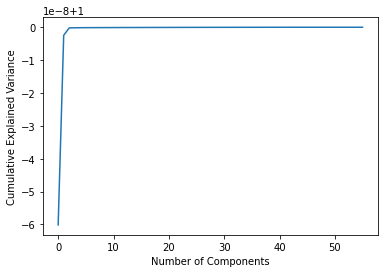

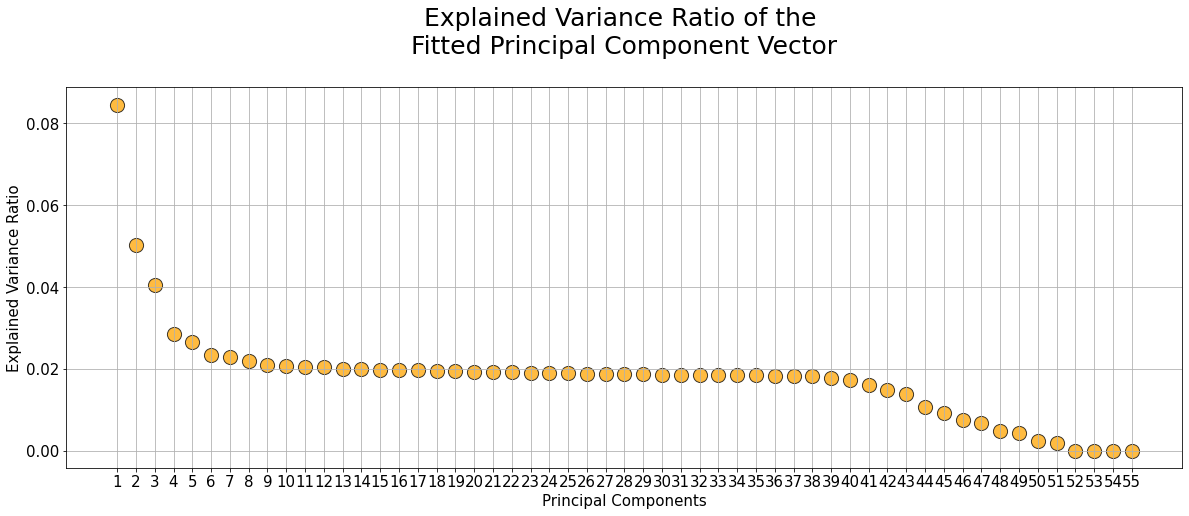

In [7]:
pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=None)
dfx_pca = pca.fit(X)
plt.figure(figsize=(20,7))
plt.scatter(x=[i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],
            y=dfx_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained Variance Ratio of the \nFitted Principal Component Vector\n",fontsize=25)
plt.xlabel("Principal Components",fontsize=15)
plt.xticks([i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained Variance Ratio",fontsize=15)
plt.show()

In [8]:
oversample = RandomOverSampler()
X_over, y_over = oversample.fit_resample(X, y)
#X_over.loc[X_over['artist_name']=="Haruka Shimotsuki,:]
pca = PCA(n_components=20)
pca.fit(X_over)
XT = pca.fit_transform(X_over)
X_train, X_test, y_train, y_test = train_test_split(XT, y_over, test_size = 0.2, random_state = 42)

## Fitting the Machine Learning models

### Random Forest Classifier

In [14]:
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
rf_pred=rfc.predict(X_test)
accuracy_score(y_test,rf_pred)

0.9114987767258802

In [50]:
precision_recall_fscore_support(y_test, rf_pred, average='macro')

(0.9109375308509704, 0.9113542088816501, 0.9096245233105287, None)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     18850
           1       0.88      0.76      0.81     18790
           2       0.89      0.95      0.92     18582
           3       1.00      1.00      1.00     18986

    accuracy                           0.91     75208
   macro avg       0.91      0.91      0.91     75208
weighted avg       0.91      0.91      0.91     75208



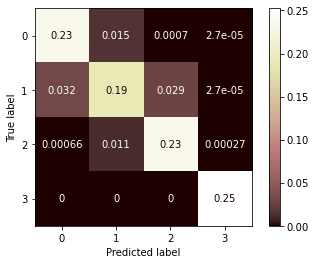

In [24]:
print(classification_report(y_test,rf_pred))
plot_confusion_matrix(rfc, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')

In [38]:
rfc.feature_importances_

array([0.09680628, 0.06335359, 0.06783629, 0.06261615, 0.0381331 ,
       0.05069094, 0.0375366 , 0.0805418 , 0.05479136, 0.04073073,
       0.04012449, 0.0389379 , 0.03794547, 0.03666884, 0.03798326,
       0.03795739, 0.04259714, 0.03527046, 0.05126458, 0.04821361])

###  Extreme Gradient Boosting Classifier (XGBoost)

In [15]:
XGB = XGBClassifier(learning_rate=0.5, n_estimators=200, 
                    objective='binary:logistic',silent=True, nthread=1)
XGB.fit(X_train, y_train)
xgb_pred = XGB.predict(X_test)
accuracy_score(y_test,xgb_pred)

[16:10:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:11:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8264679289437293

In [51]:
precision_recall_fscore_support(y_test, xgb_pred, average='macro')

(0.82673477823844, 0.8258689377418105, 0.8260059188841764, None)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     18850
           1       0.67      0.69      0.68     18790
           2       0.83      0.78      0.80     18582
           3       0.98      1.00      0.99     18986

    accuracy                           0.83     75208
   macro avg       0.83      0.83      0.83     75208
weighted avg       0.83      0.83      0.83     75208



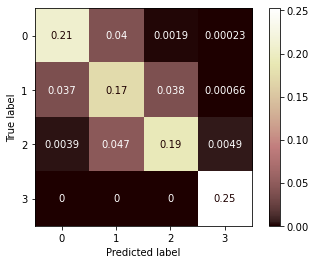

In [25]:
print(classification_report(y_test,xgb_pred))
plot_confusion_matrix(XGB, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')

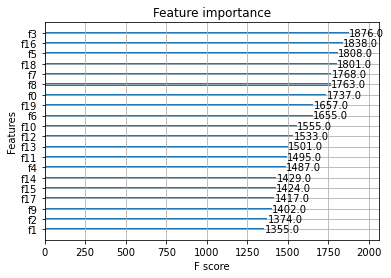

<Figure size 1152x864 with 0 Axes>

In [37]:
import xgboost as xgb
xgb.plot_importance(XGB)
plt.figure(figsize = (16, 12))
plt.show()

### Light Gradient Boosting Machine (LightGBM)

In [34]:
lgm = LGBMClassifier(objective='regression',num_leaves=31,
                              learning_rate=0.1, n_estimators=200,
                              max_bin = 100, bagging_fraction = 0.4)
lgm.fit(X_train, y_train)
pred_lgm = lgm.predict(X_test)
accuracy_score(y_test, pred_lgm)

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4


0.7801297734283587

In [49]:
precision_recall_fscore_support(y_test, pred_lgm, average='macro')

(0.7827672620417835, 0.779123711387831, 0.7770105335297209, None)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     18850
           1       0.62      0.69      0.65     18790
           2       0.80      0.63      0.70     18582
           3       0.89      1.00      0.94     18986

    accuracy                           0.78     75208
   macro avg       0.78      0.78      0.78     75208
weighted avg       0.78      0.78      0.78     75208



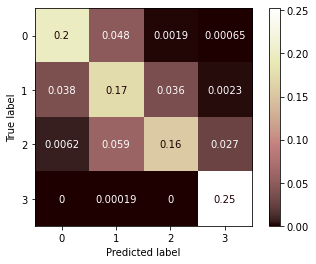

In [35]:
print(classification_report(y_test,pred_lgm))
plot_confusion_matrix(lgm, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')

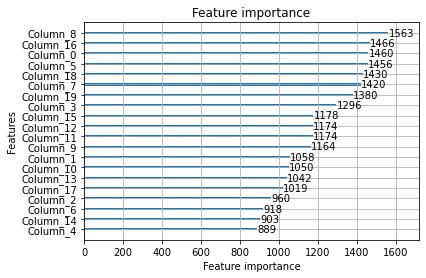

In [40]:
import lightgbm as lgb
lgb.plot_importance(lgm)
plt.show()

### Categorical Boosting (Catboost)

In [13]:
clf = CatBoostClassifier(
    iterations=1000,
  learning_rate=0.4,
  depth=5,
  colsample_bylevel=0.8,
  random_seed = 2020,
  bagging_temperature = 0.2,
  metric_period = None,
  custom_loss=['AUC', 'Accuracy']
)
clf.fit(X_train, y_train)
p=clf.predict(X_test)
accuracy_score(y_test, p)

0:	learn: 1.1740904	total: 345ms	remaining: 5m 44s
1:	learn: 1.0757383	total: 504ms	remaining: 4m 11s
2:	learn: 1.0273242	total: 672ms	remaining: 3m 43s
3:	learn: 0.9924207	total: 835ms	remaining: 3m 27s
4:	learn: 0.9705258	total: 1.01s	remaining: 3m 21s
5:	learn: 0.9474717	total: 1.17s	remaining: 3m 14s
6:	learn: 0.9363240	total: 1.33s	remaining: 3m 9s
7:	learn: 0.9218139	total: 1.49s	remaining: 3m 4s
8:	learn: 0.9135464	total: 1.66s	remaining: 3m 2s
9:	learn: 0.9074775	total: 1.8s	remaining: 2m 58s
10:	learn: 0.8992857	total: 1.97s	remaining: 2m 56s
11:	learn: 0.8935051	total: 2.13s	remaining: 2m 55s
12:	learn: 0.8885548	total: 2.29s	remaining: 2m 53s
13:	learn: 0.8802215	total: 2.45s	remaining: 2m 52s
14:	learn: 0.8751066	total: 2.62s	remaining: 2m 52s
15:	learn: 0.8700426	total: 2.77s	remaining: 2m 50s
16:	learn: 0.8647783	total: 2.94s	remaining: 2m 50s
17:	learn: 0.8620051	total: 3.1s	remaining: 2m 49s
18:	learn: 0.8581475	total: 3.27s	remaining: 2m 48s
19:	learn: 0.8544515	total:

0.803411871077545

In [48]:
precision_recall_fscore_support(y_test, p, average='macro')

(0.8033385852400712, 0.8027116612966263, 0.8024008381206513, None)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     18850
           1       0.64      0.67      0.65     18790
           2       0.80      0.74      0.77     18582
           3       0.95      1.00      0.98     18986

    accuracy                           0.80     75208
   macro avg       0.80      0.80      0.80     75208
weighted avg       0.80      0.80      0.80     75208



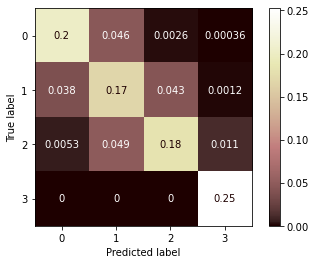

In [28]:
print(classification_report(y_test,p))
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')

### Adaptive Boosting (Adaboost) 

In [11]:
ada=AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.1,n_estimators=200,algorithm= 'SAMME')
ada.fit(X_train,y_train)
pred_ada=ada.predict(X_test)
accuracy_score(y_test, pred_ada)

0.911139772364642

In [46]:
precision_recall_fscore_support(y_test, pred_ada, average='macro')

(0.9101002121682407, 0.9109866541921727, 0.909712946023191, None)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     18850
           1       0.86      0.78      0.82     18790
           2       0.90      0.94      0.92     18582
           3       1.00      1.00      1.00     18986

    accuracy                           0.91     75208
   macro avg       0.91      0.91      0.91     75208
weighted avg       0.91      0.91      0.91     75208



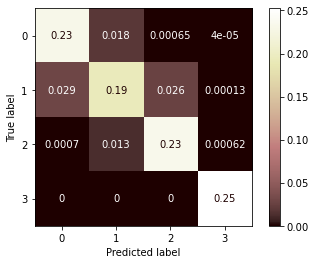

In [29]:
print(classification_report(y_test,pred_ada))
plot_confusion_matrix(ada, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')

### Cross validation and Hyperparameter tuning for light gradient boosting

#### performing hyper parameter tuning on LGBM as it gave the lowest accuracy.

In [52]:
s2=cross_val_score(lgm, X_train, y_train, cv=10,scoring='accuracy')
print(s2.mean())

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 

In [58]:
parm_range = {
        'num_leaves': [30, 50, 100, 150],
        'min_data_in_leaf': [30, 50, 100, 150],
        'bagging_fraction': [0.7, 0.8, 0.9],
    }
lg=LGBMClassifier(objective='regression',learning_rate=0.1, n_estimators=10,
                              max_bin = 100, bagging_fraction = 0.4)
lg_cv=GridSearchCV(lg,parm_range)
lg_cv.fit(X_train,y_train)

print("tuned hyperparameters :(best parameters) ",lg_cv.best_params_)
print("accuracy :",lg_cv.best_score_)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

#### The tuned hyperparameters for LGB are as follows
#### {'bagging_fraction': 0.7, 'min_data_in_leaf': 50, 'num_leaves': 150}

In [63]:
# fitting the model with the hyperparameters
lgm1 = LGBMClassifier(objective='regression',num_leaves=150,
                              learning_rate=0.1, n_estimators=200,
                              min_data_in_leaf=50,
                              max_bin = 100, bagging_fraction = 0.7)
lgm1.fit(X_train, y_train)
pred_lgm1 = lgm1.predict(X_test)
accuracy_score(y_test, pred_lgm1)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


0.8364668652271035